In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib
import torchaudio
import torch

In [181]:
# !jt -r -cellw 90%

Reset css and font defaults in:
/home/vkuzia/.jupyter/custom &
/home/vkuzia/.local/share/jupyter/nbextensions


In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
def tensor_to_img(spectrogram):
    plt.figure(figsize=(14,5)) # arbitrary, looks good on my screen.
    plt.imshow(spectrogram[0])
    plt.show()
    display(spectrogram.shape)

In [4]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [5]:
def heatmap_spectrogram(ax, spec, vmin=0, vmax=None, title=""):
    y, x = np.meshgrid(np.arange(spec.shape[1]), np.arange(spec.shape[0]))
    z = spec
    ax.pcolormesh(
        x, y, z, cmap="hot", vmin=vmin, vmax=vmax if vmax is not None else 20
    )
    ax.set_title(title)
    # set the limits of the plot to the limits of the data
    ax.axis([x.min(), x.max(), y.min(), y.max()])
#     plt.show()

In [6]:
# def plot_specgram(waveform, sample_rate=16000, title="Spectrogram", xlim=None):
#   waveform = waveform.numpy()

#   num_channels, num_frames = waveform.shape
# #   time_axis = torch.arange(0, num_frames) / sample_rate

#   figure, axes = plt.subplots(num_channels, 1)
#   if num_channels == 1:
#     axes = [axes]
#   for c in range(num_channels):
#     axes[c].specgram(waveform[c], Fs=sample_rate)
#     if num_channels > 1:
#       axes[c].set_ylabel(f'Channel {c+1}')
#     if xlim:
#       axes[c].set_xlim(xlim)
#   figure.suptitle(title)
#   plt.show(block=False)

In [7]:
class StdNormalizer(torch.nn.Module):
    
    def __call__(self, tensor):
        return (tensor - tensor.mean()) / tensor.std()
    
class MaxNormalizer(torch.nn.Module):
    
    def __call__(self, tensor):
        return tensor / tensor.max()

In [8]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    n_mels=49, hop_length=401, power=1
)

# seq_transform = torch.nn.Sequential (
#     mel_transform,
#     StdNormalizer()
# )

# seq_transform_2 = torch.nn.Sequential (
#     mel_transform,
#     MaxNormalizer()
# )

spec = torchaudio.transforms.Spectrogram(n_fft=97, hop_length=401)

In [9]:
PATH_TO_WAV = "dataset/multilingual_spoken_words/wav"
LANGUAGE = 'pl'
CSV_NAME = f'{LANGUAGE}_top_180_len_4.csv'
TO_CLIPS = "clips_tensors_no_mel"

In [186]:
df = pd.read_csv(f'{PATH_TO_WAV}/{LANGUAGE}/{CSV_NAME}', index_col=0)
df['path'] = df['path'].apply(lambda x: x.replace('.wav', '.pt'))
df.head()

,mode,label,path
0,test,albo,albo/common_voice_pl_20555575.pt
1,val,albo,albo/common_voice_pl_20555695.pt
2,test,albo,albo/common_voice_pl_20602614.pt
3,val,albo,albo/common_voice_pl_20603381.pt
4,test,albo,albo/common_voice_pl_20603528.pt


In [88]:
transform = spec

In [188]:
tensor_sum = torch.zeros((49, 40)).cuda()
for item in tqdm(df['path']):
    tensor = torch.load(f'{PATH_TO_WAV}/{LANGUAGE}/{TO_CLIPS}/{item}')
#     waveform, _ = torchaudio.load(f'{PATH_TO_WAV}/{LANGUAGE}/{TO_CLIPS}/{item}')
#     tensor = torch.zeros((49, 40))
#     t = transform(waveform).squeeze()
#     tensor[:49, :t.shape[1]] = t
    tensor_sum += tensor
tensor_sum /= len(df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86653/86653 [00:41<00:00, 2078.31it/s]


In [189]:
torch.save(tensor_sum, 'sum.pt')

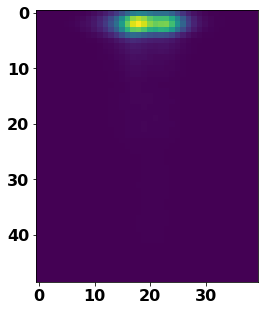

torch.Size([1, 49, 40])

In [190]:
tensor = torch.load('sum.pt').detach().cpu().unsqueeze(0)
tensor_to_img(tensor)

# tensor_2 = torch.load('sum_pl_1.pt').detach().cpu().unsqueeze(0)
# tensor_to_img(tensor_2)

# tensor_to_img(tensor-tensor_2)

/tmp/ipykernel_62431/3287924854.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(
/tmp/ipykernel_62431/964087822.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


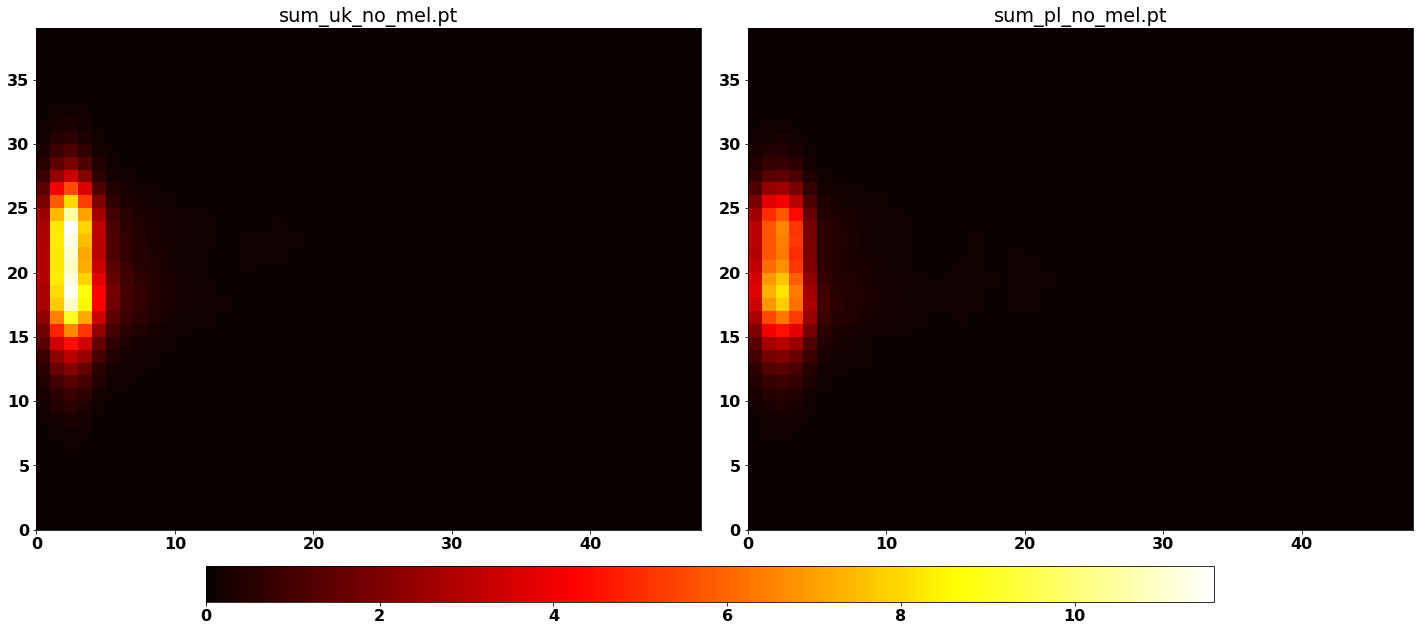

In [13]:
list_of_lists_of_tensors = [
    ["sum_uk_no_mel.pt", "sum_pl_no_mel.pt"]
]
mn = 0
mx = -1
for list_of_tensors in list_of_lists_of_tensors:
    for tensor_name in list_of_tensors:
        tensor = torch.pow(torch.load(tensor_name).cpu().unsqueeze(0), 1)
        mn = min(mn, tensor.min())
        mx = max(mx, tensor.max())


fig, axes = plt.subplots(len(list_of_lists_of_tensors), len(list_of_tensors), figsize=(20, 10))
axes = [[axes[0], axes[1]]]
axes_ = [[axes[i][j] for j in range(len(list_of_lists_of_tensors[0]))] for i in range(len(list_of_lists_of_tensors)) ]
for list_of_tensors, axes in zip(list_of_lists_of_tensors, axes_):
    for tensor_name, ax in zip(list_of_tensors, axes):
        tensor = torch.pow(torch.load(tensor_name).cpu(), 1)
        heatmap_spectrogram(ax, tensor, mn, mx, tensor_name)
        
fig.tight_layout() 
fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
# mapping = fig.axes([0.8, 0.05, 0.075, 0.8])
plt.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=mn, vmax=mx),cmap='hot'), cax=cbar_ax, orientation='horizontal')
fig.show()

/tmp/ipykernel_16845/3287924854.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(
/tmp/ipykernel_16845/909994023.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


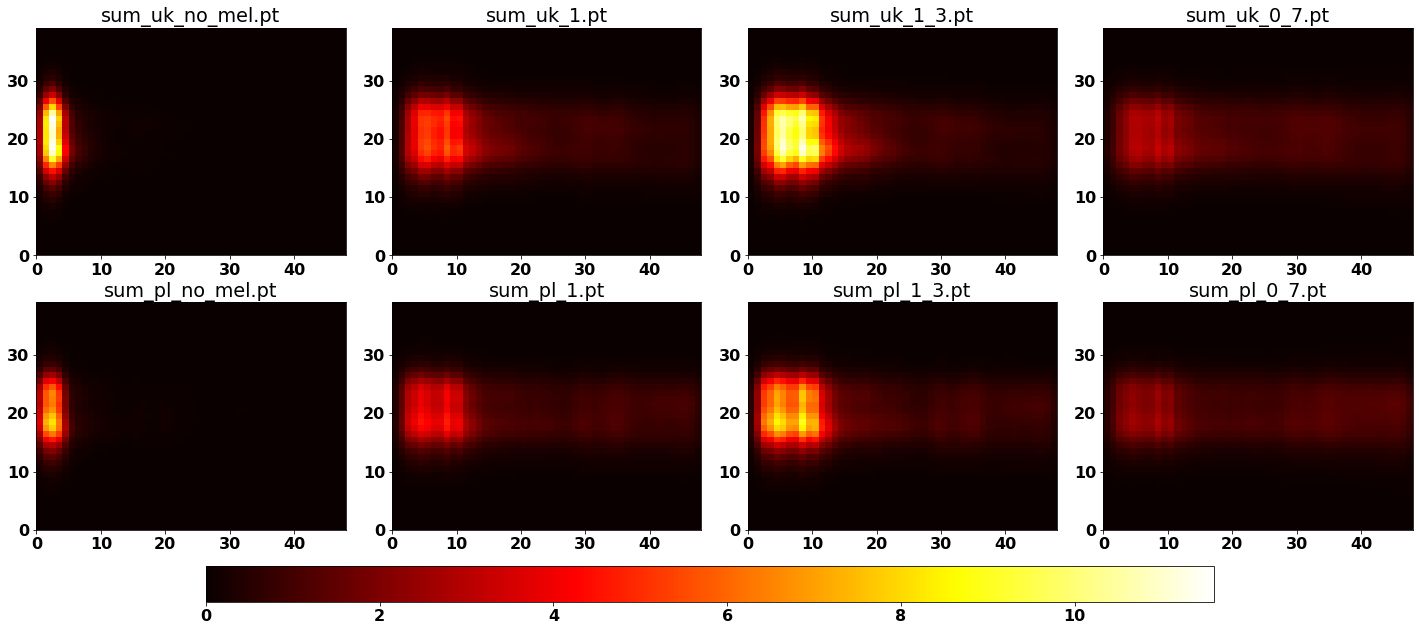

In [183]:
list_of_lists_of_tensors = [
    ["sum_uk_no_mel.pt", "sum_uk_1.pt", "sum_uk_1_3.pt", "sum_uk_0_7.pt"],
    ["sum_pl_no_mel.pt", "sum_pl_1.pt", "sum_pl_1_3.pt", "sum_pl_0_7.pt"],
]
mn = 0
mx = -1
for list_of_tensors in list_of_lists_of_tensors:
    for tensor_name in list_of_tensors:
        tensor = torch.pow(torch.load(tensor_name).cpu().unsqueeze(0), 1)
        mn = min(mn, tensor.min())
        mx = max(mx, tensor.max())


fig, axes = plt.subplots(len(list_of_lists_of_tensors), len(list_of_tensors), figsize=(20, 10))
axes_ = [[axes[i][j] for j in range(len(list_of_lists_of_tensors[0]))] for i in range(len(list_of_lists_of_tensors)) ]
for list_of_tensors, axes in zip(list_of_lists_of_tensors, axes_):
    for tensor_name, ax in zip(list_of_tensors, axes):
        tensor = torch.pow(torch.load(tensor_name).cpu(), 1)
        heatmap_spectrogram(ax, tensor, mn, mx, tensor_name)
        
fig.tight_layout() 
fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.05])
# mapping = fig.axes([0.8, 0.05, 0.075, 0.8])
plt.colorbar(matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=mn, vmax=mx),cmap='hot'), cax=cbar_ax, orientation='horizontal')
fig.show()

In [10]:
paths = ['dataset/multilingual_spoken_words/mswc_microset_wav/ru/clips/вентиляционные/common_voice_ru_18883588.wav',
        'dataset/multilingual_spoken_words/mswc_microset_wav/ru/clips/адекватные/common_voice_ru_19318965.wav',
        'dataset/multilingual_spoken_words/mswc_microset_wav/ru/clips/для/common_voice_ru_18850378.wav']

# paths = ['dataset/multilingual_spoken_words/wav/el/clips/άλλαξε/common_voice_el_20530641.wav',
#          'dataset/multilingual_spoken_words/wav/el/clips/άνθρωπο/common_voice_el_20704042.wav',
#          'dataset/multilingual_spoken_words/wav/el/clips/δεις/common_voice_el_20704004.wav']

waveforms = torch.stack([torchaudio.load(path)[0] for path in paths])
spectrograms = transform(waveforms)
mel_spectrograms = mel_transform(waveforms)
for waveform in waveforms:
#     plot_spectrogram(transform(waveform))
    tensor_to_img(transform(waveform))
    tensor_to_img(mel_transform(waveform))
    tensor_to_img(seq_transform(waveform))
    tensor_to_img(seq_transform_2(waveform))

formats: can't open input file `dataset/multilingual_spoken_words/mswc_microset_wav/ru/clips/вентиляционные/common_voice_ru_18883588.wav': No such file or directory


RuntimeError: Error loading audio file: failed to open file dataset/multilingual_spoken_words/mswc_microset_wav/ru/clips/вентиляционные/common_voice_ru_18883588.wav

In [8]:
for waveform in waveforms:
    print("---------------")
    for tf in [transform, mel_transform, seq_transform, seq_transform_2]:
        numpied = tf(waveform)[0].numpy()
        print(numpied.min(), numpied.max(), numpied.mean())
        print((numpied > 0.01).sum())
#         display(numpied.shape)
#         valueable = 0
#         total = 0
#         values = []
#         for row in numpied:
#             for value in row:
#                 values.append(value)
#                 total += 1
#                 if value > 0.01:
#                     valueable += 1
#                 if value > 0.1:
#                     print(value)
#                 if value < 0:
#                     print("------------", value)
#         print(valueable/ total)

---------------
1.5195848e-13 1.5525577 0.009565964
119
4.4729986e-05 3.5812213 0.22809249
1215
-0.48340908 7.1078672 3.1140384e-08
433
1.2490148e-05 1.0 0.06369125
831
---------------
1.5195848e-13 3.6558259 0.013865863
84
4.0272487e-05 6.420605 0.2949589
1223
-0.41104308 8.537624 0.0
412
6.2723816e-06 1.0 0.045939423
669
---------------
6.378419e-17 9.489116 0.017232383
112
3.031327e-05 7.3278356 0.31491587
1287
-0.38879707 8.659027 0.0
414
4.136729e-06 1.0 0.042975288
786


In [9]:
spectrograms = torch.stack([mel_transform(waveform) for waveform in waveforms])

In [10]:
freq_transform = torchaudio.transforms.FrequencyMasking(2)
time_transform = torchaudio.transforms.TimeMasking(2)
stretch_transform = torchaudio.transforms.TimeStretch(n_freq = 49, fixed_rate=0.95)
stretch_transform_2 = torchaudio.transforms.TimeStretch(n_freq = 49, fixed_rate=1.05)

In [11]:
def pad(tensors, to_len = 40):
    zeros = torch.zeros(size=(len(tensors), 49, to_len))
    for i, tensor in enumerate(tensors):
        print(tensor.shape)
        if tensor.shape[-1] <= to_len:
            zeros[i, :, :tensor.shape[-1]] = tensor
        else:
            print(tensor[:, :, :to_len].shape)
            zeros[i, :, :] = tensor[:, :, :to_len]
    return zeros

In [162]:
# for spec in spectrograms:
#     tensor_to_img(spec)
#     for transform in [freq_transform, time_transform]:
#         tensor_to_img(transform(spec))
#     modified = torch.complex(spec, torch.zeros(spec.shape))
#     tensor_to_img(torch.real(stretch_transform(modified)))
#     tensor_to_img(torch.real(stretch_transform_2(modified)))

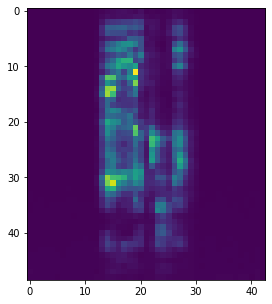

torch.Size([1, 49, 43])

NameError: name 'stretched2' is not defined

In [12]:
spec = spectrograms[0]
modified = torch.complex(spec, torch.zeros(spec.shape))
stretched = torch.real(stretch_transform(modified))
stretched_2 = torch.real(stretch_transform_2(modified))
tensor_to_img(stretched)
tensor_to_img(stretched2)
tensor_to_img(pad([stretched]))
tensor_to_img(pad([stretched_2]))
tensor_to_img(pad())

In [29]:
torch.save(mel_transform(waveforms[0]), 'experiment.pt')

In [201]:
spectrogram = torch.load('experiment.pt')

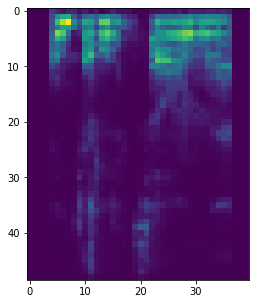

torch.Size([1, 49, 40])

In [202]:
tensor_to_img(spectrogram)

In [167]:
import random

def happen(prob):
    return random.random() < prob 

In [168]:
class TimeShifter:
    def __init__(self, shift: int, forward_probability: float = 0.5):
        self.forward_probability = forward_probability
        self.shift = shift

    def __call__(self, spectrogram: torch.Tensor) -> torch.Tensor:
        if happen(self.forward_probability):
            return torch.roll(spectrogram,
                              shifts=(self.shift,),
                              dims=(len(spectrogram.shape) - 1))
        else:
            return torch.roll(spectrogram,
                              shifts=(-self.shift,),
                              dims=(len(spectrogram.shape) - 1))

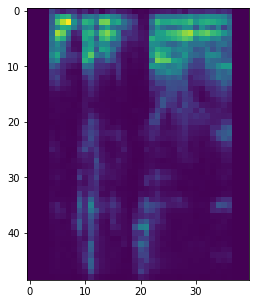

torch.Size([1, 49, 40])

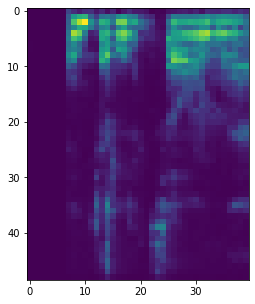

torch.Size([1, 49, 40])

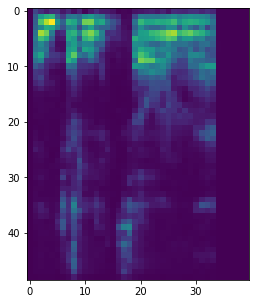

torch.Size([1, 49, 40])

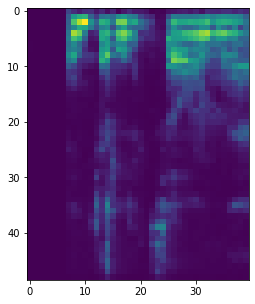

torch.Size([1, 49, 40])

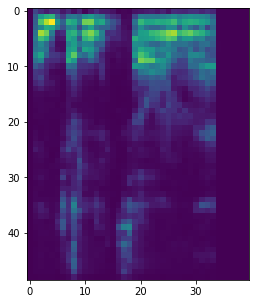

torch.Size([1, 49, 40])

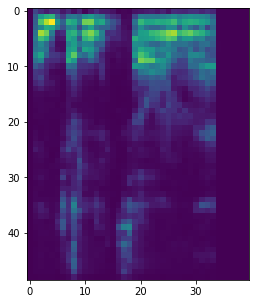

torch.Size([1, 49, 40])

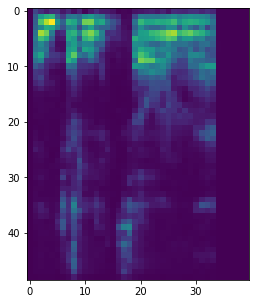

torch.Size([1, 49, 40])

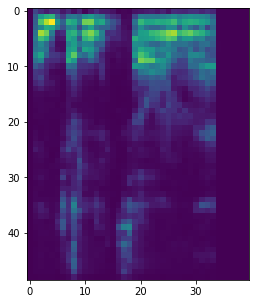

torch.Size([1, 49, 40])

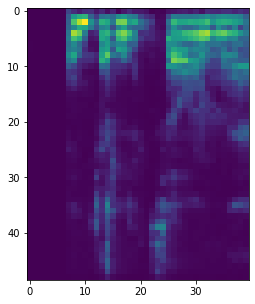

torch.Size([1, 49, 40])

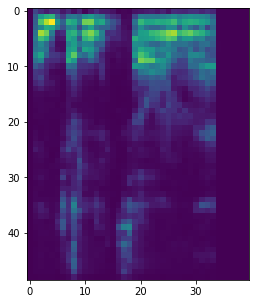

torch.Size([1, 49, 40])

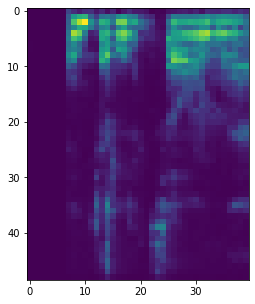

torch.Size([1, 49, 40])

In [169]:
tensor_to_img(spectrograms[0])
shifter = TimeShifter(3)
for _ in range(10):
    tensor_to_img(shifter(spectrograms[0]))

In [29]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None, figsize=(10, 5)):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=figsize)
    if num_channels == 1:
        axes = [axes]

    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [73]:
def sign(x):
#     print(x)
    y = 1 if x >= 0 else -1
#     print(y)
    return y

def enpower(array, power):
    return torch.Tensor([(abs(x)**power) * sign(x) for x in array.reshape(-1)]).reshape((1, -1))


def print_info(tensor):
    print(tensor.max(), tensor.min(), tensor.sum())

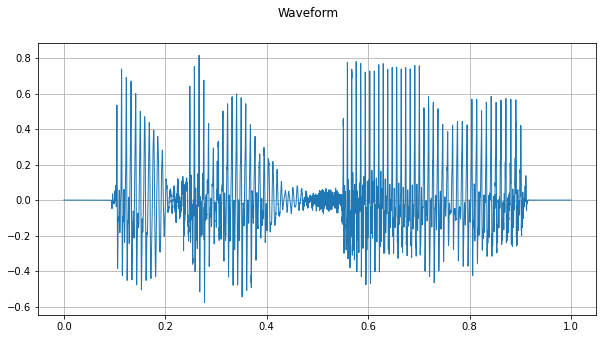

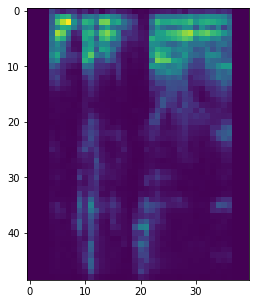

torch.Size([1, 49, 40])

tensor(12.3458) tensor(8.8506e-05) tensor(2508.9976)


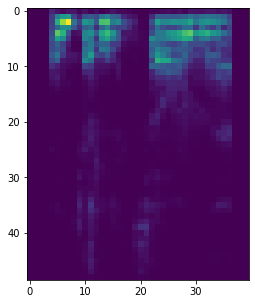

torch.Size([1, 49, 40])

tensor(36.2518) tensor(1.6968e-06) tensor(3860.9587)


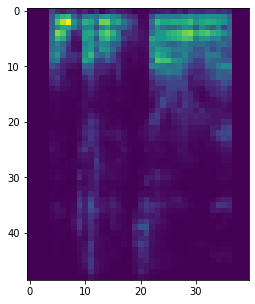

torch.Size([1, 49, 40])

tensor(12.3461) tensor(9.1356e-05) tensor(2179.9702)


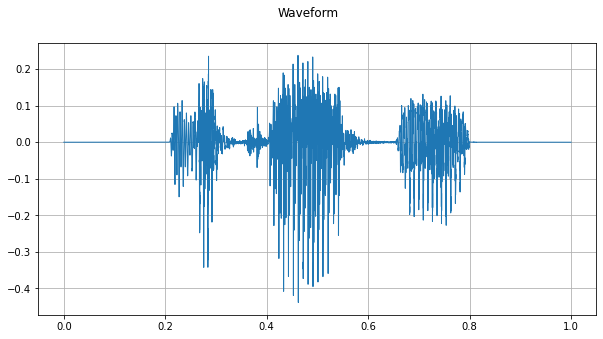

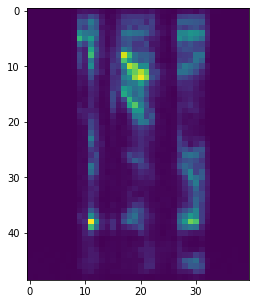

torch.Size([1, 49, 40])

tensor(7.8142) tensor(7.4316e-05) tensor(1083.5360)


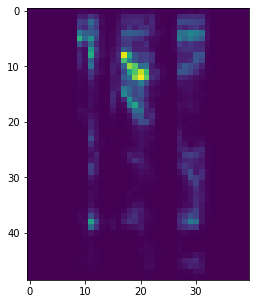

torch.Size([1, 49, 40])

tensor(15.1489) tensor(1.3182e-06) tensor(1080.0989)


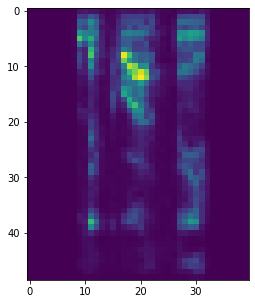

torch.Size([1, 49, 40])

tensor(6.7030) tensor(7.6555e-05) tensor(863.4782)


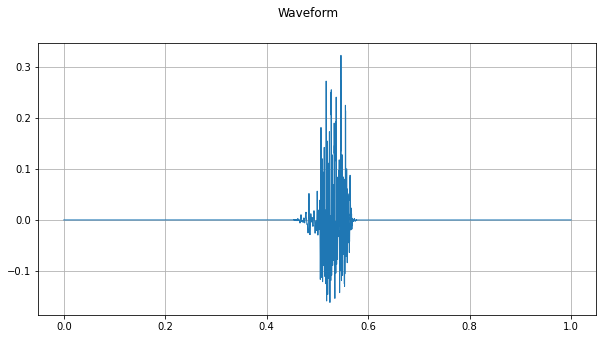

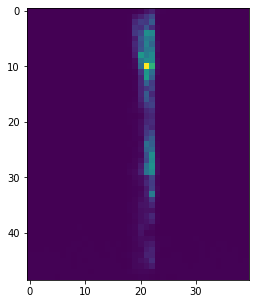

torch.Size([1, 49, 40])

tensor(7.1141) tensor(6.0082e-05) tensor(216.0034)


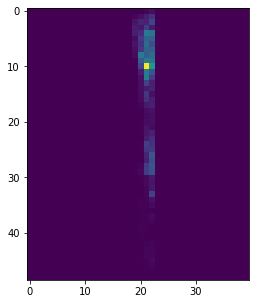

torch.Size([1, 49, 40])

tensor(13.4157) tensor(9.7568e-07) tensor(206.1789)


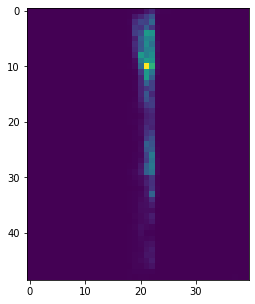

torch.Size([1, 49, 40])

tensor(6.1564) tensor(6.2018e-05) tensor(173.6639)


In [74]:
import IPython.display as ipd

paths = [
    "dataset/multilingual_spoken_words/wav/ru/clips/вентиляционные/common_voice_ru_18883588.wav",
    "dataset/multilingual_spoken_words/wav/ru/clips/адекватные/common_voice_ru_19318965.wav",
    "dataset/multilingual_spoken_words/wav/ru/clips/для/common_voice_ru_18850378.wav",
]
# ipd.Audio('audio/conga_groove.wav')
# print(paths[0])


power = 0.7

transform_1 = torchaudio.transforms.MelSpectrogram(
    n_mels=49, hop_length=401, power=power
)

transform_2 = torchaudio.transforms.MelSpectrogram(n_mels=49, hop_length=401, power=1)

for path in paths:
    waveform, sample_rate = torchaudio.load(path)
    plot_waveform(waveform, sample_rate)
    mel_1 = transform_1(waveform)
    mel_2 = transform_2(waveform)
    mel_3 = mel_2.pow(power)

    tensor_to_img(mel_1)

    print_info(mel_1)
    tensor_to_img(mel_2)

    print_info(mel_2)
    tensor_to_img(mel_3)
    print_info(mel_3)


#     display(ipd.Audio(waveform, rate=sample_rate))
#     waveform2 = enpower(waveform, power)
#     plot_waveform(waveform2, sample_rate)
#     display(ipd.Audio(waveform2, rate=sample_rate))
#     zero = mel_transform_2(waveform)
#     first = mel_transform(waveform)
#     second = mel_transform_2(waveform) ** power
#     a = mel(waveform)
#     third = mel_transform_2(waveform2)
#     tensor_to_img(first)
#     tensor_to_img(second)
#     tensor_to_img(a)
#     tensor_to_img(third)
#     tensor_to_img(torch.abs(first - second))
#     print(first.max(), second.max())
#     print(first.min(), second.min())
#     print(torch.abs(first - second).max(), torch.abs(first - third).max(), torch.abs(second - third).max())
#     tensor_to_img(third)
#     print(torch.equal(first, second))
#     print(torch.equal(first, third))

In [ ]:


transforms = [
    ()
]